In [26]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from neurolib.models.multimodel import (
    FitzHughNagumoNetwork,
    FitzHughNagumoNode,
    MultiModel,
)

# `MultiModel` advanced topics
In the last two examples we showcased the basics of `MultiModel` framework and how to create a new model from scratch. Now we will look at some advanced topics such as how exactly the integration works, why we have two integration backends, and how to run optimisation and exploration with `MultiModel`.

## The tale of two backends
In the current implementation of `MultiModel`, users may choose from two different integration backends. Before diving into the details of both backends, let us quickly revise how exactly `MultiModel` integrates the model equations.

### The how
Almost all whole-brain simulators works in the sense, that you define the dynamics of single brain area and then we have a double loop for integration: one over time, the second over brain areas. In other words, all brain areas have the same dynamics. In pseudo-code it would look something like:
```python
for t in range(time_total):
    for n in range(num_areas):
        x[t, n] = integrate_step(x[t-max_delay:t-1, :])
```
Since all areas are the same, the `integrate_step` function would simply take the history of state vector and apply one integration step in any scheme. This won't work in `MultiModel`, since it allows building heterogeneous models. The internal workings of `MultiModel` can be explained in couple of steps.

#### State vector
Since the inner loop in the pseudocode above is not doable in `MultiModel` due to heterogeneity, we solve it simply by concatenating all individual equations into one big state vector (that is also the reason why all `NeuralMass` and `Node` objects have their indices). When the model is ready for simulation, we iterate over `Nodes` and `NeuralMasses` within these nodes and stack their equations into a single list. The concatenation is done using the `_derivatives()` function.
- in `NeuralMass`, the `_derivatives()` function implements the actual dynamics as delay differential equations
- in `Node`, the `_derivatives()` function stacks all equations from `NeuralMasses` within this `Node` into one list
- in `Network`, the `_derivatives()` function stacks all equations from `Nodes` within this `Network`.

Let us see how it looks like:

In [11]:
# create a FitzHugh-Nagumo Node
fhn_node = FitzHughNagumoNode()
# necessary attributes when creating a Node from scratch
fhn_node.index = 0
fhn_node.idx_state_var = 0
fhn_node.init_node()

display(fhn_node._derivatives())
display(len(fhn_node._derivatives()), fhn_node.num_state_variables)

[1.0 + 4.0*current_y(0)**2 - 3.0*current_y(0)**3 - 1.5*current_y(0) - current_y(1) + past_y(-external_input + t, input_base_n, anchors(-external_input + t)),
 0.05*(current_y(0) - 0.5*current_y(1)) + past_y(-external_input + t, 1 + input_base_n, anchors(-external_input + t))]

2

2

As we see, the `_derivatives()` function return a list of equations, in this case of length 2 (which is, of course, equal to `fhn.num_state_variables`). The `current_y(<index>)` lingo is taken from `jitcdde`. As written above, all equations are symbolic and therefore `current_y(<index>)` is a `symengine` `Symbol` representing state vector with index `<index>` at current time `t`. In other words, `current_y(0)` is the first variable (in FitzHugh-Nagumo model, this is the $x$), while `current_y(1)` is the second variable (the $y$). The `past_y()` lingo is the same, but encodes either the past of the state vector, i.e. delayed interactions, or the external input (noise or stimulus). In this case it represents the external input (you can tell since it is `past_y(-external_input...)`). Now let us see how it looks like for network:

In [19]:
# create 2 node FHN network
SC = np.array([[0.0, 1.43], [0.64, 0.0]])
delays = np.array([[0.0, 10.0], [10.0, 0.0]])
fhn_net = FitzHughNagumoNetwork(SC, delays)

display(len(fhn_net._derivatives()), fhn_net.num_state_variables)
display(fhn_net._derivatives())

4

4

[1.0 + network_x_0 + 4.0*current_y(0)**2 - 3.0*current_y(0)**3 - 1.5*current_y(0) - current_y(1) + past_y(-external_input + t, input_base_n, anchors(-external_input + t)),
 network_y_0 + 0.05*(current_y(0) - 0.5*current_y(1)) + past_y(-external_input + t, 1 + input_base_n, anchors(-external_input + t)),
 1.0 + network_x_1 + 4.0*current_y(2)**2 - 3.0*current_y(2)**3 - 1.5*current_y(2) - current_y(3) + past_y(-external_input + t, 2 + input_base_n, anchors(-external_input + t)),
 network_y_1 + 0.05*(current_y(2) - 0.5*current_y(3)) + past_y(-external_input + t, 3 + input_base_n, anchors(-external_input + t))]

Now, since we have 2 nodes, the total number of state variables is 4. And now, we see equations for the whole network as a list of 4 symbolic equations. In the network equations we see a new symbol: `network_x_0` and `network_x_1`. At this time, these are really just `symengine` symbols, but they actually represent the coupling between the nodes. And that is also a topic of the next section.

#### Coupling
As we have seen before, the state vector encodes the whole dynamics of the brain model, but the coupling is crypted as symbol. To make things easier for simulating, we had to separate the individual internal dynamics from the coupling terms. The coupling comes in two flavours, reflecting the three levels of hierarchy: node coupling takes care of coupling between `NeuralMasses` within one `Node`, and network coupling takes care of coupling between `Nodes` in one `Network`. The coupling is implemented as `_sync()` function. This function returns a list, where each item is a tuple of length two: `(name_of_the_symbol, symbolic_term_representing_the_coupling)`. The FitzHugh-Nagumo model only has one mass per node, hence there are no node couplings, but we can inspect the network coupling:

In [20]:
display(fhn_net._sync())

[(network_x_0,
  1.43*(-current_y(0) + past_y(-10.0 + t, 2, anchors(-10.0 + t)))),
 (network_x_1,
  0.64*(-current_y(2) + past_y(-10.0 + t, 0, anchors(-10.0 + t)))),
 (network_y_0, 0.0),
 (network_y_1, 0.0)]

In this particular case, we have 2 coupling variables and 2 nodes, hence 4 coupling terms. The coupling of $y$ is zero. As per the coupling of $x$ variables between nodes, you can now see how it works: `network_x_0` just means that we are about to define a network coupling of variable `x` for the first node, and it is just 1.43 (this is the SC matrix we passed when creating FHN network) times state variable with index 2 at time -10 milliseconds minus current state variable index 0 (diffusive coupling). Similarly for node 1 (with different coupling strength and state variable indices, of course).

Now when symbols from `_sync()` function are inserted into `_derivatives()` at the proper places, we have a full definition of a model. This is exactly what both backends do: they gather the equations (`_derivatives()`), look up the coupling terms (`_sync()`) and integrate the model forward in time.

### `jitcdde` backend
The `jitcdde` backend was the first integration backend in `MultiModel`. The name stems from the fact that we use wonderful [`jitcdde`](https://jitcdde.readthedocs.io/en/stable/) python package. It employs just-in-time compilation of symbolic derivatives into C and then uses DDE integration method proposed by Shampine and Thompson, which in turn employs the Bogacki–Shampine Runge–Kutta pair. This is the reason why the definition of dynamics in `MultiModel` is done using symbolic derivatives written in `symengine`. It uses adaptive `dt` scheme, hence is very useful for stiff problems. Also, if you are implementing a new model and have no idea how stiff the dynamics are, this is the backend to try first. It has reasonable speed, but for large networks and long simulations it is not the best.

The internal workings of `jitcdde` package served as an inspiration when creating `MultiModel`. `jitcdde` naturally works with dynamics defined as symbolic equations (`_derivatives()`) and it also supports the use of "helpers" - the helpers in our case are the coupling terms (`_sync()`).

/Users/nikola/.virtualenvs/neurolib/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
100%|██████████| 2000/2000 [00:00<00:00, 91658.74it/s]

Using default integration parameters.


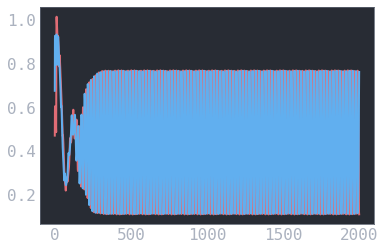

In [31]:
fhn_mm = MultiModel(fhn_net)
# 2 second run
fhn_mm.params["duration"] = 2000.0
fhn_mm.params["backend"] = "jitcdde"
# jitcdde works with adaptive dt, you only set sampling dt
fhn_mm.params["sampling_dt"] = 1.0
fhn_mm.run()

plt.plot(fhn_mm.x.T)

### `numba` backend
Since `jitcdde` is rather slow, in particular for long runs or large networks, we created a `numba` backend. It was tricky - the whole code around `MultiModel` was creating with `jitcdde` in mind with the symbolic equations, helpers, etc. However, the advantage of symbolic equations is also - they are purely symbolic, so you can "print" them. By printing, you really just obtain the string with equations. So what `numba` backend actually does?
1. gather all symbolic equations with `_derivatives()`
2. substitute coupling symbols with functional terms in `_sync()`
3. substitute current and past state vector symbols (`current_y()` and `past_y()`) with state vector `y` with correct indices and time delays
4. now we have a complete description of `dy`
5. "print" out this `dy` into prepared function template (string) inside the time for loop, you can imagine it as
```python
for t in range(1, t_max):
      dy = np.array({dy}) # <- `dy` is printed here
      y[:, t] = y[:, t-1] + dt*dy
```
6. compile the prepared string template into an actual python function (yes, python can do this)
7. wrap the compiled function with `numba.njit()` to get the speed boots
8. profit

And yes, the `numba` backend simply employs Euler integration scheme, which means that you need to think about dt.

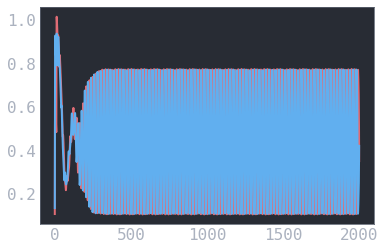

In [32]:
fhn_mm = MultiModel(fhn_net)
# 2 second run
fhn_mm.params["duration"] = 2000.0
fhn_mm.params["backend"] = "numba"
# numba uses Euler scheme so dt is important!
fhn_mm.params["dt"] = 0.1
fhn_mm.params["sampling_dt"] = 1.0
fhn_mm.run()

plt.plot(fhn_mm.x.T)

## Which backend to use and when?
By default `numba` backend is almost always faster (with the exception of small network and not too long runs, when they perform similarly). However, for prototyping new models, or connecting couple of models into a heterogeneous network, it is always a good idea to do a couple of short simulations with `jitcdde`. The reason is - it uses an adaptive dt, so you do not need to worry about setting a correct dt. When you have an idea about what the dynamics should look like and how fast it is, you can switch to `numba` and try couple of different dt and select the one, when the results are closest to `jitcdde` results. For exploration and optimisation with evolution, always use `numba`. `numba` backend is actually compiling a jit'ed function with all the parameters as arguments, hence for exploration, only one compilation is necessary and then even when changing parameters, the model runs at high speed.